# Multimodal Image Search Demo

This notebook demonstrates:
1. Basic search using CLIP
2. Hybrid search using CLIP + BLIP-2 for better accuracy

## Setup

In [1]:
from src.dataset import Flickr30KDataset
from src.encoder import CLIPEncoder
from src.index import FAISSIndex
from src.search import SearchEngine
from src.reranker import BLIP2Reranker
from src.hybrid_search import HybridSearchEngine
import matplotlib.pyplot as plt

## Load Components

In [3]:
# Load dataset
dataset = Flickr30KDataset('data/images', 'data/results.csv')

# Load encoder
encoder = CLIPEncoder()

# Load indices
image_index = FAISSIndex()
image_index.load('data/indices/image_index.faiss')

text_index = FAISSIndex()
text_index.load('data/indices/text_index.faiss')

# Create search engine
engine = SearchEngine(encoder, image_index, text_index, dataset)
print("Ready!")

Loaded 158915 captions for 31783 images
Loading CLIP model on cuda...


d:\Giáo trình 20251\IT3930E - Project III\hybrid_multimodal_retrieval\venv\Lib\site-packages\open_clip\factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Model loaded!
Index loaded: 31783 vectors
Index loaded: 158914 vectors
Ready!
Index loaded: 158914 vectors
Ready!


## Text-to-Image Search

In [6]:
# Search for images
query = "a park playing in the dog"
results = engine.text_to_image(query, k=5)

print(f"Query: '{query}'\n")
for i, (img_name, score) in enumerate(results, 1):
    print(f"{i}. {img_name} (score: {score:.4f})")

Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]

Query: 'a park playing in the dog'

1. 2612040125.jpg (score: 0.3203)
2. 3540416139.jpg (score: 0.3143)
3. 3676561090.jpg (score: 0.3123)
4. 774009278.jpg (score: 0.3080)
5. 2956562716.jpg (score: 0.3077)


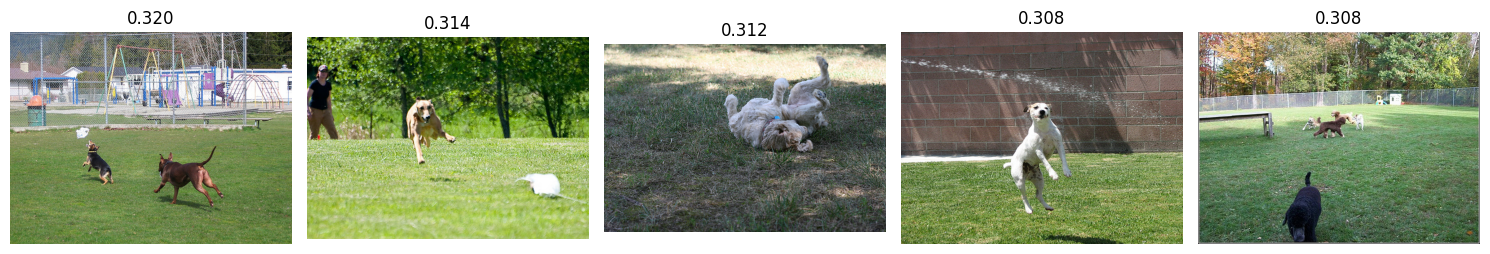

In [7]:
# Visualize results
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (img_name, score) in enumerate(results):
    img = dataset.get_image(img_name)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'{score:.3f}')
plt.tight_layout()
plt.show()

## Image-to-Text Search

In [8]:
# Use first result from above
test_image = results[0][0]
captions = engine.image_to_text(f'data/images/{test_image}', k=5)

print(f"Image: {test_image}\n")
for i, (caption, score) in enumerate(captions, 1):
    print(f"{i}. {caption}")
    print(f"   Score: {score:.4f}\n")

Encoding images: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

Image: 2612040125.jpg

1. Two large black dogs , one with a ball in its mouth , are running through tall grass .
   Score: 0.3718

2. A born dog carries some fruit in his mouth while two other dogs follow him .
   Score: 0.3523

3. Two large dogs are fighting with teeth bared near some trees .
   Score: 0.3481

4. A dog rolls on his back in the grass as two other dogs look on .
   Score: 0.3479

5. A man jumping .
   Score: 0.3454



## Image-to-Image Search

In [12]:
# Find similar images
similar = engine.image_to_image(f'data/images/{test_image}', k=6)

print(f"Query image: {test_image}\n")
for i, (img_name, score) in enumerate(similar, 1):
    print(f"{i}. {img_name} (score: {score:.4f})")

Encoding images: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]

Query image: 2612040125.jpg

1. 2612040125.jpg (score: 1.0000)
2. 441212506.jpg (score: 0.8667)
3. 3584829998.jpg (score: 0.8653)
4. 3627216820.jpg (score: 0.8618)
5. 3510219078.jpg (score: 0.8523)
6. 1814086703.jpg (score: 0.8448)


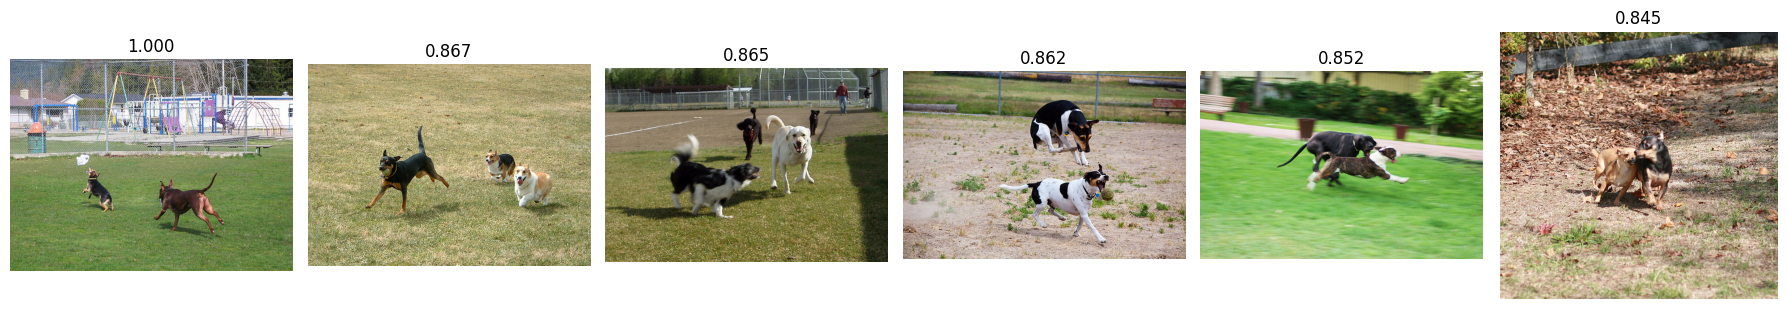

In [13]:
# Visualize similar images
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
for i, (img_name, score) in enumerate(similar):
    img = dataset.get_image(img_name)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'{score:.3f}')
plt.tight_layout()
plt.show()

## Hybrid Search (CLIP + BLIP-2)

Hybrid search uses two stages:
1. CLIP retrieves top 50 candidates (fast)
2. BLIP-2 re-ranks them to find best 5 (accurate)

In [ ]:
# Load BLIP-2 re-ranker
print("Loading BLIP-2...")
reranker = BLIP2Reranker()

# Create hybrid search engine (correct parameter order)
hybrid_engine = HybridSearchEngine(encoder, reranker, image_index, dataset)
print("Ready!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP-2...
Loading BLIP-2 on cuda...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

d:\Giáo trình 20251\IT3930E - Project III\hybrid_multimodal_retrieval\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ACER\.cache\huggingface\hub\models--Salesforce--blip2-opt-2.7b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


LookupError: <ContextVar name='shell_parent' at 0x000002A0CC0438D0>

In [ ]:
# Compare CLIP-only vs Hybrid search
query = "children playing soccer"

print("=== CLIP Only (single stage) ===")
clip_results = engine.text_to_image(query, k=5)
for i, (img_name, score) in enumerate(clip_results, 1):
    print(f"{i}. {img_name} (score: {score:.4f})")

print("\n=== Hybrid (CLIP + BLIP-2) ===")
hybrid_results = hybrid_engine.search(query, k1=50, k2=5)
for i, (img_name, score) in enumerate(hybrid_results, 1):
    print(f"{i}. {img_name} (score: {score:.4f})")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Top row: CLIP results
for i, (img_name, score) in enumerate(clip_results):
    img = dataset.get_image(img_name)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'CLIP: {score:.3f}')

# Bottom row: Hybrid results  
for i, (img_name, score) in enumerate(hybrid_results):
    img = dataset.get_image(img_name)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Hybrid: {score:.3f}')

plt.suptitle(f"Query: '{query}'")
plt.tight_layout()
plt.show()

## Random Query

In [ ]:
# Change this to test different queries
my_query = "a black dog running"

results = hybrid_engine.search(my_query, k1=100, k2=5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (img_name, score) in enumerate(results):
    img = dataset.get_image(img_name)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'{score:.3f}')
plt.suptitle(f"Hybrid Search: '{my_query}'")
plt.tight_layout()
plt.show()